In [1]:
import numpy as np
import random
import time
import math
import random
import os
import sys
from datetime import datetime

# Notebook path
current_directory = os.getcwd()
# Get one behind for calling the other modules
root_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(root_directory)

#Network and measures
from to_get_data.net_construction_vis_measures import *
#Agrobiodiversity
from to_get_data.agrobiodiversity_data import *
#Classes
from model_class.Variety import Variety

# UD for endogamy

# 1. Experiments with beta fixed

In [3]:
#This experiment has the beta fixed in 0.06
prob_morte = 0.06
n = 4
m = 50
malphas = np.linspace(1,n,n) # Average number of children: from 1 to n
mbetas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
mM = np.empty((len(malphas), len(mbetas)), dtype=object)
punto_vista = 2
tiempo = 600
tempo = list(range(0,tiempo,punto_vista))
experiments = 40

# For data of behaviour
datos_1 = np.empty((len(malphas), len(mbetas)), dtype=object)
print(mM.shape)
start = time.time()
print(f"started at:  {datetime.now()}")
for i, media in enumerate(malphas):
    for j, iniciais  in enumerate(mbetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        original_media = media
        for experiment in range(1, experiments+1):
            #### Initialization
            ## Comunidades
            UD.uds = {}
            comunidades_disponibles = [i for i in range(1, (int(iniciais) // 10) + 1) for _ in range(10)]
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                instancias_ud.append(UD(id_ud, media, comunidades_disponibles.pop(0)))
            ## Variedades y repartirlas entre las comunidades
            for id_ud, ud in UD.uds.items():
                for _ in range(5):
                    ud.varieties.append(Variety())    
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                #uds_copy = dict(UD.uds)
                uds_copy = {id_ud: ud for id_ud, ud in UD.uds.items() if ud.activa}
                if not uds_copy:
                    # Only 0
                    print(f"acabó en 0 el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                #any_ud_active = False
                #alive = len([1 for id, ud in uds_copy.items() if ud.activa])
#                 if alive > 200 and (media == original_media): #or media == original_media-1):
#                     media -= media//2
#                     if media >= 4:
#                         media = media //2
#                     print(media)
#                 elif alive < 150 and media < original_media:
#                     media = original_media
#                     print(media)                
                for id_ud, ud in uds_copy.items():
                    #if ud.activa == True:
                    any_ud_active = True
                    ud.ter_filho()
                    ud.buscar_ud(int(media),0, True)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
#                 if not any_ud_active:
#                     # Only 0
#                     print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
#                     vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
#                     vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
#                     #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
#                     break
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
#                 if t%100 == 0:
#                     print(f"tamos en tiempo {t} con vivas {viv}")
            # Average Annual Population Growth
            # First 0 avoid errors 
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Get growth rate before the 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                # Growth rate
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        media = original_media
        end_config = time.time()
        mM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration}
        datos_1[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of mean {media} and initial UDs {iniciais} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'resultados_parametros_endogamy'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'filhos_unidadesiniciais_endogamy.npy')
np.save(heat_std, mM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'filhos_unidadesiniciais_datos_endogamy.npy')
np.save(behavior, datos_1)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(4, 5)
started at:  2024-05-13 09:16:46.385353
acabó en 0 el experimento 1 de la media 1.0 con unidades 10.0
acabó en el experimento 1 de la media 1.0 con unidades 10.0
acabó en 0 el experimento 2 de la media 1.0 con unidades 10.0
acabó en el experimento 2 de la media 1.0 con unidades 10.0
acabó en 0 el experimento 3 de la media 1.0 con unidades 10.0
acabó en el experimento 3 de la media 1.0 con unidades 10.0
acabó en 0 el experimento 4 de la media 1.0 con unidades 10.0
acabó en el experimento 4 de la media 1.0 con unidades 10.0
acabó en 0 el experimento 5 de la media 1.0 con unidades 10.0
acabó en el experimento 5 de la media 1.0 con unidades 10.0
acabó en 0 el experimento 6 de la media 1.0 con unidades 10.0
acabó en el experimento 6 de la media 1.0 con unidades 10.0
acabó en 0 el experimento 7 de la media 1.0 con unidades 10.0
acabó en el experimento 7 de la media 1.0 con unidades 10.0
acabó en 0 el experimento 8 de la media 1.0 con unidades 10.0
acabó en el experimento 8 de la media

acabó en 0 el experimento 35 de la media 1.0 con unidades 20.0
acabó en el experimento 35 de la media 1.0 con unidades 20.0
acabó en 0 el experimento 36 de la media 1.0 con unidades 20.0
acabó en el experimento 36 de la media 1.0 con unidades 20.0
acabó en 0 el experimento 37 de la media 1.0 con unidades 20.0
acabó en el experimento 37 de la media 1.0 con unidades 20.0
acabó en 0 el experimento 38 de la media 1.0 con unidades 20.0
acabó en el experimento 38 de la media 1.0 con unidades 20.0
acabó en 0 el experimento 39 de la media 1.0 con unidades 20.0
acabó en el experimento 39 de la media 1.0 con unidades 20.0
acabó en 0 el experimento 40 de la media 1.0 con unidades 20.0
acabó en el experimento 40 de la media 1.0 con unidades 20.0

The total time of the configuration of mean 1.0 and initial UDs 20.0 is  0.40279126167297363
        
acabó en 0 el experimento 1 de la media 1.0 con unidades 30.0
acabó en el experimento 1 de la media 1.0 con unidades 30.0
acabó en 0 el experimento 2 de 

acabó en 0 el experimento 22 de la media 1.0 con unidades 40.0
acabó en el experimento 22 de la media 1.0 con unidades 40.0
acabó en 0 el experimento 23 de la media 1.0 con unidades 40.0
acabó en el experimento 23 de la media 1.0 con unidades 40.0
acabó en 0 el experimento 24 de la media 1.0 con unidades 40.0
acabó en el experimento 24 de la media 1.0 con unidades 40.0
acabó en 0 el experimento 25 de la media 1.0 con unidades 40.0
acabó en el experimento 25 de la media 1.0 con unidades 40.0
acabó en 0 el experimento 26 de la media 1.0 con unidades 40.0
acabó en el experimento 26 de la media 1.0 con unidades 40.0
acabó en 0 el experimento 27 de la media 1.0 con unidades 40.0
acabó en el experimento 27 de la media 1.0 con unidades 40.0
acabó en 0 el experimento 28 de la media 1.0 con unidades 40.0
acabó en el experimento 28 de la media 1.0 con unidades 40.0
acabó en 0 el experimento 29 de la media 1.0 con unidades 40.0
acabó en el experimento 29 de la media 1.0 con unidades 40.0
acabó en

acabó en 0 el experimento 22 de la media 2.0 con unidades 10.0
acabó en el experimento 22 de la media 2.0 con unidades 10.0
acabó en 0 el experimento 23 de la media 2.0 con unidades 10.0
acabó en el experimento 23 de la media 2.0 con unidades 10.0
acabó en 0 el experimento 24 de la media 2.0 con unidades 10.0
acabó en el experimento 24 de la media 2.0 con unidades 10.0
acabó en 0 el experimento 25 de la media 2.0 con unidades 10.0
acabó en el experimento 25 de la media 2.0 con unidades 10.0
acabó en 0 el experimento 26 de la media 2.0 con unidades 10.0
acabó en el experimento 26 de la media 2.0 con unidades 10.0
acabó en 0 el experimento 27 de la media 2.0 con unidades 10.0
acabó en el experimento 27 de la media 2.0 con unidades 10.0
acabó en 0 el experimento 28 de la media 2.0 con unidades 10.0
acabó en el experimento 28 de la media 2.0 con unidades 10.0
acabó en 0 el experimento 29 de la media 2.0 con unidades 10.0
acabó en el experimento 29 de la media 2.0 con unidades 10.0
acabó en

acabó en 0 el experimento 9 de la media 2.0 con unidades 30.0
acabó en el experimento 9 de la media 2.0 con unidades 30.0
acabó en 0 el experimento 10 de la media 2.0 con unidades 30.0
acabó en el experimento 10 de la media 2.0 con unidades 30.0
acabó en 0 el experimento 11 de la media 2.0 con unidades 30.0
acabó en el experimento 11 de la media 2.0 con unidades 30.0
acabó en 0 el experimento 12 de la media 2.0 con unidades 30.0
acabó en el experimento 12 de la media 2.0 con unidades 30.0
acabó en 0 el experimento 13 de la media 2.0 con unidades 30.0
acabó en el experimento 13 de la media 2.0 con unidades 30.0
acabó en 0 el experimento 14 de la media 2.0 con unidades 30.0
acabó en el experimento 14 de la media 2.0 con unidades 30.0
acabó en 0 el experimento 15 de la media 2.0 con unidades 30.0
acabó en el experimento 15 de la media 2.0 con unidades 30.0
acabó en 0 el experimento 16 de la media 2.0 con unidades 30.0
acabó en el experimento 16 de la media 2.0 con unidades 30.0
acabó en 0

acabó en 0 el experimento 36 de la media 2.0 con unidades 40.0
acabó en el experimento 36 de la media 2.0 con unidades 40.0
acabó en 0 el experimento 37 de la media 2.0 con unidades 40.0
acabó en el experimento 37 de la media 2.0 con unidades 40.0
acabó en 0 el experimento 38 de la media 2.0 con unidades 40.0
acabó en el experimento 38 de la media 2.0 con unidades 40.0
acabó en 0 el experimento 39 de la media 2.0 con unidades 40.0
acabó en el experimento 39 de la media 2.0 con unidades 40.0
acabó en 0 el experimento 40 de la media 2.0 con unidades 40.0
acabó en el experimento 40 de la media 2.0 con unidades 40.0

The total time of the configuration of mean 2.0 and initial UDs 40.0 is  3.4539458751678467
        
acabó en 0 el experimento 1 de la media 2.0 con unidades 50.0
acabó en el experimento 1 de la media 2.0 con unidades 50.0
acabó en 0 el experimento 2 de la media 2.0 con unidades 50.0
acabó en el experimento 2 de la media 2.0 con unidades 50.0
acabó en 0 el experimento 3 de la 

acabó en 0 el experimento 22 de la media 3.0 con unidades 10.0
acabó en el experimento 22 de la media 3.0 con unidades 10.0
acabó en 0 el experimento 23 de la media 3.0 con unidades 10.0
acabó en el experimento 23 de la media 3.0 con unidades 10.0
acabó en 0 el experimento 24 de la media 3.0 con unidades 10.0
acabó en el experimento 24 de la media 3.0 con unidades 10.0
acabó en 0 el experimento 25 de la media 3.0 con unidades 10.0
acabó en el experimento 25 de la media 3.0 con unidades 10.0
acabó en 0 el experimento 26 de la media 3.0 con unidades 10.0
acabó en el experimento 26 de la media 3.0 con unidades 10.0
acabó en 0 el experimento 27 de la media 3.0 con unidades 10.0
acabó en el experimento 27 de la media 3.0 con unidades 10.0
acabó en 0 el experimento 28 de la media 3.0 con unidades 10.0
acabó en el experimento 28 de la media 3.0 con unidades 10.0
acabó en 0 el experimento 29 de la media 3.0 con unidades 10.0
acabó en el experimento 29 de la media 3.0 con unidades 10.0
acabó en

acabó en 0 el experimento 8 de la media 3.0 con unidades 30.0
acabó en el experimento 8 de la media 3.0 con unidades 30.0
acabó en 0 el experimento 9 de la media 3.0 con unidades 30.0
acabó en el experimento 9 de la media 3.0 con unidades 30.0
acabó en 0 el experimento 10 de la media 3.0 con unidades 30.0
acabó en el experimento 10 de la media 3.0 con unidades 30.0
acabó en 0 el experimento 11 de la media 3.0 con unidades 30.0
acabó en el experimento 11 de la media 3.0 con unidades 30.0
acabó en el experimento 12 de la media 3.0 con unidades 30.0
acabó en 0 el experimento 13 de la media 3.0 con unidades 30.0
acabó en el experimento 13 de la media 3.0 con unidades 30.0
acabó en 0 el experimento 14 de la media 3.0 con unidades 30.0
acabó en el experimento 14 de la media 3.0 con unidades 30.0
acabó en 0 el experimento 15 de la media 3.0 con unidades 30.0
acabó en el experimento 15 de la media 3.0 con unidades 30.0
acabó en 0 el experimento 16 de la media 3.0 con unidades 30.0
acabó en el 

acabó en 0 el experimento 40 de la media 3.0 con unidades 40.0
acabó en el experimento 40 de la media 3.0 con unidades 40.0

The total time of the configuration of mean 3.0 and initial UDs 40.0 is  35.47116732597351
        
acabó en 0 el experimento 1 de la media 3.0 con unidades 50.0
acabó en el experimento 1 de la media 3.0 con unidades 50.0
acabó en 0 el experimento 2 de la media 3.0 con unidades 50.0
acabó en el experimento 2 de la media 3.0 con unidades 50.0
acabó en el experimento 3 de la media 3.0 con unidades 50.0
acabó en 0 el experimento 4 de la media 3.0 con unidades 50.0
acabó en el experimento 4 de la media 3.0 con unidades 50.0
acabó en 0 el experimento 5 de la media 3.0 con unidades 50.0
acabó en el experimento 5 de la media 3.0 con unidades 50.0
acabó en 0 el experimento 6 de la media 3.0 con unidades 50.0
acabó en el experimento 6 de la media 3.0 con unidades 50.0
acabó en 0 el experimento 7 de la media 3.0 con unidades 50.0
acabó en el experimento 7 de la media 3.0 c

acabó en el experimento 32 de la media 4.0 con unidades 10.0
acabó en el experimento 33 de la media 4.0 con unidades 10.0
acabó en el experimento 34 de la media 4.0 con unidades 10.0
acabó en 0 el experimento 35 de la media 4.0 con unidades 10.0
acabó en el experimento 35 de la media 4.0 con unidades 10.0
acabó en 0 el experimento 36 de la media 4.0 con unidades 10.0
acabó en el experimento 36 de la media 4.0 con unidades 10.0
acabó en 0 el experimento 37 de la media 4.0 con unidades 10.0
acabó en el experimento 37 de la media 4.0 con unidades 10.0
acabó en 0 el experimento 38 de la media 4.0 con unidades 10.0
acabó en el experimento 38 de la media 4.0 con unidades 10.0
acabó en 0 el experimento 39 de la media 4.0 con unidades 10.0
acabó en el experimento 39 de la media 4.0 con unidades 10.0
acabó en 0 el experimento 40 de la media 4.0 con unidades 10.0
acabó en el experimento 40 de la media 4.0 con unidades 10.0

The total time of the configuration of mean 4.0 and initial UDs 10.0 is 

acabó en el experimento 32 de la media 4.0 con unidades 40.0
acabó en el experimento 33 de la media 4.0 con unidades 40.0
acabó en el experimento 34 de la media 4.0 con unidades 40.0
acabó en el experimento 35 de la media 4.0 con unidades 40.0
acabó en el experimento 36 de la media 4.0 con unidades 40.0
acabó en el experimento 37 de la media 4.0 con unidades 40.0
acabó en el experimento 38 de la media 4.0 con unidades 40.0
acabó en el experimento 39 de la media 4.0 con unidades 40.0
acabó en el experimento 40 de la media 4.0 con unidades 40.0

The total time of the configuration of mean 4.0 and initial UDs 40.0 is  19173.28366446495
        
acabó en el experimento 1 de la media 4.0 con unidades 50.0
acabó en el experimento 2 de la media 4.0 con unidades 50.0
acabó en el experimento 3 de la media 4.0 con unidades 50.0
acabó en el experimento 4 de la media 4.0 con unidades 50.0
acabó en el experimento 5 de la media 4.0 con unidades 50.0
acabó en el experimento 6 de la media 4.0 con unid

In [3]:
# Dowload the documents
#As a reference
n = 4
m = 50
malphas = np.linspace(1,n,n) # Average number of children: from 1 to n
mbetas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
#Folders
folder_name = 'resultados_parametros_endogamy'
heat_std = os.path.join(folder_name, 'filhos_unidadesiniciais_endogamy.npy')
behavior = os.path.join(folder_name, 'filhos_unidadesiniciais_datos_endogamy.npy')
## heatmap and mean
mM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
mM_behavior = np.load(behavior, allow_pickle=True)

Text(0.5, 0, 'Unidades iniciais')

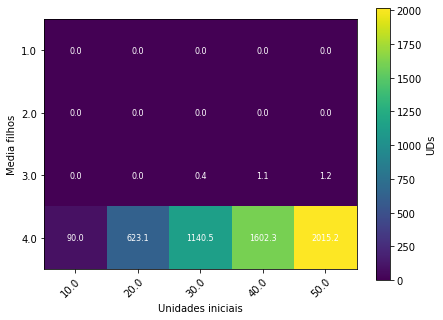

In [4]:
#Heatmap. 
#Get the vales from the document.
alive_values = np.array([[entry['alive'] for entry in row] for row in mM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(mbetas)))
ax.set_yticks(np.arange(len(malphas)))
ax.set_xticklabels(mbetas)
ax.set_yticklabels(malphas)
#Size
for i in range(len(malphas)):
    for j in range(len(mbetas)):
        ax.text(j, i, f'{alive_values[i, j]:.1f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Unidades iniciais")

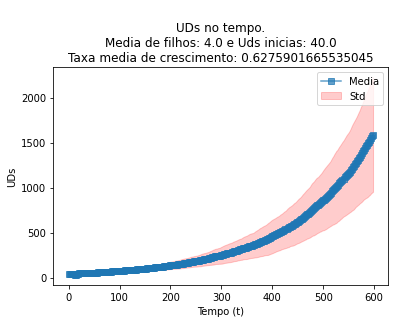

In [6]:
#Graph of experiment with mean and std
x = 3
y = 3

# Main line
plt.plot(mM_behavior[y][x]['tempo'], mM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(mM_behavior[y][x]['tempo'], mM_behavior[y][x]['mean'] - mM_behavior[y][x]['std'],
                 mM_behavior[y][x]['mean'] + mM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Media de filhos: {malphas[y]} e Uds inicias: {mbetas[x]}
Taxa media de crescimento: {mM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

# 2. Experiment of children and beta.
UDs iniciais 30

In [3]:
#This experiment has Uds inicias in 30
iniciais = 30
n = 4
ualphas = np.linspace(1,n,n) # Average number of children: from 1 to n
ubetas = np.arange(0.055, 0.07 + 0.005, 0.005) # Beta from 0.045 to 0.065
uM = np.empty((len(ualphas), len(ubetas)), dtype=object)
punto_vista = 2
tiempo = 600
tempo = list(range(0,tiempo,punto_vista))
experiments = 40

start = time.time()
# For data of behaviour
datos_2 = np.empty((len(ualphas), len(ubetas)), dtype=object)
print(uM.shape)

for i, media in enumerate(ualphas):
    for j, prob_morte  in enumerate(ubetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        original_media = media
        for experiment in range(1, experiments+1):
            #### Initialization
            ## Comunidades
            UD.uds = {}
            comunidades_disponibles = [i for i in range(1, (int(iniciais) // 10) + 1) for _ in range(10)]
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                instancias_ud.append(UD(id_ud, media, comunidades_disponibles.pop(0)))
            ## Variedades y repartirlas entre las comunidades
            for id_ud, ud in UD.uds.items():
                for _ in range(5):
                    ud.varieties.append(Variety())    
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                #uds_copy = dict(UD.uds)
                uds_copy = {id_ud: ud for id_ud, ud in UD.uds.items() if ud.activa}
                if not uds_copy:
                    # Only 0
                    print(f"acabó en el experimento {experiment} de la media {ualphas[i]} con prob de morte {ubetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                #any_ud_active = False
                #alive = len([1 for id, ud in uds_copy.items() if ud.activa])
#                 if alive > 200 and (media == original_media): #or media == original_media-1):
#                     media -= media//2
#                     if media >= 4:
#                         media = media //2
#                     print(media)
#                 elif alive < 150 and media < original_media:
#                     media = original_media
#                     print(media)                
                for id_ud, ud in uds_copy.items():
                    if ud.activa == True:
                        any_ud_active = True
                        ud.ter_filho()
                        ud.buscar_ud(int(media),0, True)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
#                 if not any_ud_active:
#                     # Only 0
#                     print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
#                     vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
#                     vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
#                     #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
#                     break

                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
#                 if t%100 == 0:
#                     print(f"tamos en tiempo {t} con vivas {viv}")
            # Average Annual Population Growth
            # First 0 avoid errors 
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Get growth rate before the 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                # Growth rate
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            print(f"acabó en el experimento {experiment} de la media {ualphas[i]} con prob de morte {ubetas[j]}")
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        media = original_media
        end_config = time.time()
        uM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration}
        datos_2[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of mean {original_media} and beta {prob_morte:.3f} is  {end_config - star_configuration}
        """)
# Folders and save
folder_name = 'resultados_parametros_endogamy'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'filhos_morte_endogamy.npy')
np.save(heat_std, uM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'filhos_morte_datos_endogamy.npy')
np.save(behavior, datos_2)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(4, 5)
acabó en el experimento 1 de la media 1.0 con prob de morte 0.055
acabó en el experimento 1 de la media 1.0 con prob de morte 0.055
acabó en el experimento 2 de la media 1.0 con prob de morte 0.055
acabó en el experimento 2 de la media 1.0 con prob de morte 0.055
acabó en el experimento 3 de la media 1.0 con prob de morte 0.055
acabó en el experimento 3 de la media 1.0 con prob de morte 0.055
acabó en el experimento 4 de la media 1.0 con prob de morte 0.055
acabó en el experimento 4 de la media 1.0 con prob de morte 0.055
acabó en el experimento 5 de la media 1.0 con prob de morte 0.055
acabó en el experimento 5 de la media 1.0 con prob de morte 0.055
acabó en el experimento 6 de la media 1.0 con prob de morte 0.055
acabó en el experimento 6 de la media 1.0 con prob de morte 0.055
acabó en el experimento 7 de la media 1.0 con prob de morte 0.055
acabó en el experimento 7 de la media 1.0 con prob de morte 0.055
acabó en el experimento 8 de la media 1.0 con prob de morte 0.055
aca

acabó en el experimento 26 de la media 1.0 con prob de morte 0.06
acabó en el experimento 26 de la media 1.0 con prob de morte 0.06
acabó en el experimento 27 de la media 1.0 con prob de morte 0.06
acabó en el experimento 27 de la media 1.0 con prob de morte 0.06
acabó en el experimento 28 de la media 1.0 con prob de morte 0.06
acabó en el experimento 28 de la media 1.0 con prob de morte 0.06
acabó en el experimento 29 de la media 1.0 con prob de morte 0.06
acabó en el experimento 29 de la media 1.0 con prob de morte 0.06
acabó en el experimento 30 de la media 1.0 con prob de morte 0.06
acabó en el experimento 30 de la media 1.0 con prob de morte 0.06
acabó en el experimento 31 de la media 1.0 con prob de morte 0.06
acabó en el experimento 31 de la media 1.0 con prob de morte 0.06
acabó en el experimento 32 de la media 1.0 con prob de morte 0.06
acabó en el experimento 32 de la media 1.0 con prob de morte 0.06
acabó en el experimento 33 de la media 1.0 con prob de morte 0.06
acabó en e

acabó en el experimento 6 de la media 1.0 con prob de morte 0.06999999999999999
acabó en el experimento 6 de la media 1.0 con prob de morte 0.06999999999999999
acabó en el experimento 7 de la media 1.0 con prob de morte 0.06999999999999999
acabó en el experimento 7 de la media 1.0 con prob de morte 0.06999999999999999
acabó en el experimento 8 de la media 1.0 con prob de morte 0.06999999999999999
acabó en el experimento 8 de la media 1.0 con prob de morte 0.06999999999999999
acabó en el experimento 9 de la media 1.0 con prob de morte 0.06999999999999999
acabó en el experimento 9 de la media 1.0 con prob de morte 0.06999999999999999
acabó en el experimento 10 de la media 1.0 con prob de morte 0.06999999999999999
acabó en el experimento 10 de la media 1.0 con prob de morte 0.06999999999999999
acabó en el experimento 11 de la media 1.0 con prob de morte 0.06999999999999999
acabó en el experimento 11 de la media 1.0 con prob de morte 0.06999999999999999
acabó en el experimento 12 de la med

acabó en el experimento 32 de la media 1.0 con prob de morte 0.07499999999999998
acabó en el experimento 32 de la media 1.0 con prob de morte 0.07499999999999998
acabó en el experimento 33 de la media 1.0 con prob de morte 0.07499999999999998
acabó en el experimento 33 de la media 1.0 con prob de morte 0.07499999999999998
acabó en el experimento 34 de la media 1.0 con prob de morte 0.07499999999999998
acabó en el experimento 34 de la media 1.0 con prob de morte 0.07499999999999998
acabó en el experimento 35 de la media 1.0 con prob de morte 0.07499999999999998
acabó en el experimento 35 de la media 1.0 con prob de morte 0.07499999999999998
acabó en el experimento 36 de la media 1.0 con prob de morte 0.07499999999999998
acabó en el experimento 36 de la media 1.0 con prob de morte 0.07499999999999998
acabó en el experimento 37 de la media 1.0 con prob de morte 0.07499999999999998
acabó en el experimento 37 de la media 1.0 con prob de morte 0.07499999999999998
acabó en el experimento 38 d

acabó en el experimento 14 de la media 2.0 con prob de morte 0.06
acabó en el experimento 14 de la media 2.0 con prob de morte 0.06
acabó en el experimento 15 de la media 2.0 con prob de morte 0.06
acabó en el experimento 15 de la media 2.0 con prob de morte 0.06
acabó en el experimento 16 de la media 2.0 con prob de morte 0.06
acabó en el experimento 16 de la media 2.0 con prob de morte 0.06
acabó en el experimento 17 de la media 2.0 con prob de morte 0.06
acabó en el experimento 17 de la media 2.0 con prob de morte 0.06
acabó en el experimento 18 de la media 2.0 con prob de morte 0.06
acabó en el experimento 18 de la media 2.0 con prob de morte 0.06
acabó en el experimento 19 de la media 2.0 con prob de morte 0.06
acabó en el experimento 19 de la media 2.0 con prob de morte 0.06
acabó en el experimento 20 de la media 2.0 con prob de morte 0.06
acabó en el experimento 20 de la media 2.0 con prob de morte 0.06
acabó en el experimento 21 de la media 2.0 con prob de morte 0.06
acabó en e

acabó en el experimento 40 de la media 2.0 con prob de morte 0.065
acabó en el experimento 40 de la media 2.0 con prob de morte 0.065

The total time of the configuration of mean 2.0 and beta 0.065 is  1.942627191543579
        
acabó en el experimento 1 de la media 2.0 con prob de morte 0.06999999999999999
acabó en el experimento 1 de la media 2.0 con prob de morte 0.06999999999999999
acabó en el experimento 2 de la media 2.0 con prob de morte 0.06999999999999999
acabó en el experimento 2 de la media 2.0 con prob de morte 0.06999999999999999
acabó en el experimento 3 de la media 2.0 con prob de morte 0.06999999999999999
acabó en el experimento 3 de la media 2.0 con prob de morte 0.06999999999999999
acabó en el experimento 4 de la media 2.0 con prob de morte 0.06999999999999999
acabó en el experimento 4 de la media 2.0 con prob de morte 0.06999999999999999
acabó en el experimento 5 de la media 2.0 con prob de morte 0.06999999999999999
acabó en el experimento 5 de la media 2.0 con prob 

acabó en el experimento 11 de la media 2.0 con prob de morte 0.07499999999999998
acabó en el experimento 11 de la media 2.0 con prob de morte 0.07499999999999998
acabó en el experimento 12 de la media 2.0 con prob de morte 0.07499999999999998
acabó en el experimento 12 de la media 2.0 con prob de morte 0.07499999999999998
acabó en el experimento 13 de la media 2.0 con prob de morte 0.07499999999999998
acabó en el experimento 13 de la media 2.0 con prob de morte 0.07499999999999998
acabó en el experimento 14 de la media 2.0 con prob de morte 0.07499999999999998
acabó en el experimento 14 de la media 2.0 con prob de morte 0.07499999999999998
acabó en el experimento 15 de la media 2.0 con prob de morte 0.07499999999999998
acabó en el experimento 15 de la media 2.0 con prob de morte 0.07499999999999998
acabó en el experimento 16 de la media 2.0 con prob de morte 0.07499999999999998
acabó en el experimento 16 de la media 2.0 con prob de morte 0.07499999999999998
acabó en el experimento 17 d

acabó en el experimento 27 de la media 3.0 con prob de morte 0.055
acabó en el experimento 27 de la media 3.0 con prob de morte 0.055
acabó en el experimento 28 de la media 3.0 con prob de morte 0.055
acabó en el experimento 28 de la media 3.0 con prob de morte 0.055
acabó en el experimento 29 de la media 3.0 con prob de morte 0.055
acabó en el experimento 29 de la media 3.0 con prob de morte 0.055
acabó en el experimento 30 de la media 3.0 con prob de morte 0.055
acabó en el experimento 30 de la media 3.0 con prob de morte 0.055
acabó en el experimento 31 de la media 3.0 con prob de morte 0.055
acabó en el experimento 31 de la media 3.0 con prob de morte 0.055
acabó en el experimento 32 de la media 3.0 con prob de morte 0.055
acabó en el experimento 33 de la media 3.0 con prob de morte 0.055
acabó en el experimento 34 de la media 3.0 con prob de morte 0.055
acabó en el experimento 34 de la media 3.0 con prob de morte 0.055
acabó en el experimento 35 de la media 3.0 con prob de morte 0

acabó en el experimento 11 de la media 3.0 con prob de morte 0.065
acabó en el experimento 11 de la media 3.0 con prob de morte 0.065
acabó en el experimento 12 de la media 3.0 con prob de morte 0.065
acabó en el experimento 12 de la media 3.0 con prob de morte 0.065
acabó en el experimento 13 de la media 3.0 con prob de morte 0.065
acabó en el experimento 13 de la media 3.0 con prob de morte 0.065
acabó en el experimento 14 de la media 3.0 con prob de morte 0.065
acabó en el experimento 14 de la media 3.0 con prob de morte 0.065
acabó en el experimento 15 de la media 3.0 con prob de morte 0.065
acabó en el experimento 15 de la media 3.0 con prob de morte 0.065
acabó en el experimento 16 de la media 3.0 con prob de morte 0.065
acabó en el experimento 16 de la media 3.0 con prob de morte 0.065
acabó en el experimento 17 de la media 3.0 con prob de morte 0.065
acabó en el experimento 17 de la media 3.0 con prob de morte 0.065
acabó en el experimento 18 de la media 3.0 con prob de morte 0

acabó en el experimento 27 de la media 3.0 con prob de morte 0.06999999999999999
acabó en el experimento 27 de la media 3.0 con prob de morte 0.06999999999999999
acabó en el experimento 28 de la media 3.0 con prob de morte 0.06999999999999999
acabó en el experimento 28 de la media 3.0 con prob de morte 0.06999999999999999
acabó en el experimento 29 de la media 3.0 con prob de morte 0.06999999999999999
acabó en el experimento 29 de la media 3.0 con prob de morte 0.06999999999999999
acabó en el experimento 30 de la media 3.0 con prob de morte 0.06999999999999999
acabó en el experimento 30 de la media 3.0 con prob de morte 0.06999999999999999
acabó en el experimento 31 de la media 3.0 con prob de morte 0.06999999999999999
acabó en el experimento 31 de la media 3.0 con prob de morte 0.06999999999999999
acabó en el experimento 32 de la media 3.0 con prob de morte 0.06999999999999999
acabó en el experimento 32 de la media 3.0 con prob de morte 0.06999999999999999
acabó en el experimento 33 d

acabó en el experimento 39 de la media 3.0 con prob de morte 0.07499999999999998
acabó en el experimento 40 de la media 3.0 con prob de morte 0.07499999999999998
acabó en el experimento 40 de la media 3.0 con prob de morte 0.07499999999999998

The total time of the configuration of mean 3.0 and beta 0.075 is  5.899235010147095
        
acabó en el experimento 1 de la media 4.0 con prob de morte 0.055
acabó en el experimento 2 de la media 4.0 con prob de morte 0.055
acabó en el experimento 3 de la media 4.0 con prob de morte 0.055
acabó en el experimento 4 de la media 4.0 con prob de morte 0.055
acabó en el experimento 5 de la media 4.0 con prob de morte 0.055
acabó en el experimento 6 de la media 4.0 con prob de morte 0.055
acabó en el experimento 7 de la media 4.0 con prob de morte 0.055
acabó en el experimento 8 de la media 4.0 con prob de morte 0.055
acabó en el experimento 9 de la media 4.0 con prob de morte 0.055
acabó en el experimento 10 de la media 4.0 con prob de morte 0.055
a

acabó en el experimento 37 de la media 4.0 con prob de morte 0.065
acabó en el experimento 38 de la media 4.0 con prob de morte 0.065
acabó en el experimento 38 de la media 4.0 con prob de morte 0.065
acabó en el experimento 39 de la media 4.0 con prob de morte 0.065
acabó en el experimento 40 de la media 4.0 con prob de morte 0.065

The total time of the configuration of mean 4.0 and beta 0.065 is  1583.669481754303
        
acabó en el experimento 1 de la media 4.0 con prob de morte 0.06999999999999999
acabó en el experimento 1 de la media 4.0 con prob de morte 0.06999999999999999
acabó en el experimento 2 de la media 4.0 con prob de morte 0.06999999999999999
acabó en el experimento 3 de la media 4.0 con prob de morte 0.06999999999999999
acabó en el experimento 4 de la media 4.0 con prob de morte 0.06999999999999999
acabó en el experimento 5 de la media 4.0 con prob de morte 0.06999999999999999
acabó en el experimento 6 de la media 4.0 con prob de morte 0.06999999999999999
acabó en e

acabó en el experimento 35 de la media 4.0 con prob de morte 0.07499999999999998
acabó en el experimento 36 de la media 4.0 con prob de morte 0.07499999999999998
acabó en el experimento 36 de la media 4.0 con prob de morte 0.07499999999999998
acabó en el experimento 37 de la media 4.0 con prob de morte 0.07499999999999998
acabó en el experimento 37 de la media 4.0 con prob de morte 0.07499999999999998
acabó en el experimento 38 de la media 4.0 con prob de morte 0.07499999999999998
acabó en el experimento 39 de la media 4.0 con prob de morte 0.07499999999999998
acabó en el experimento 39 de la media 4.0 con prob de morte 0.07499999999999998
acabó en el experimento 40 de la media 4.0 con prob de morte 0.07499999999999998
acabó en el experimento 40 de la media 4.0 con prob de morte 0.07499999999999998

The total time of the configuration of mean 4.0 and beta 0.075 is  72.83444237709045
        

It finished at: 2024-05-21 06:47:44.414023
It lasted 82018.69995617867

done


In [4]:
# Dowload the documents
#As reference
n = 4
ualphas = np.linspace(1,n,n) # Average number of children: from 1 to n
ubetas = np.arange(0.055, 0.07 + 0.005, 0.005) # Beta from 0.05 to 0.075
#Folders
folder_name = 'resultados_parametros_endogamy'
heat_std = os.path.join(folder_name, 'filhos_morte_endogamy.npy')
behavior = os.path.join(folder_name, 'filhos_morte_datos_endogamy.npy')
## heatmap and mean
uM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
uM_behavior = np.load(behavior, allow_pickle=True)

Text(0.5, 0, 'Beta')

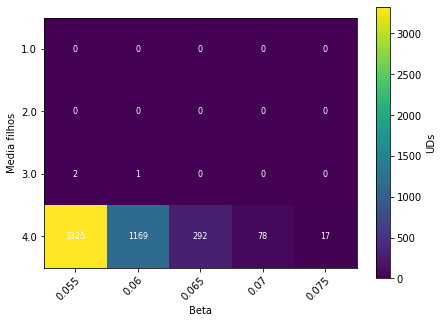

In [5]:
#Heatmap. 
alive_values = np.array([[entry['alive'] for entry in row] for row in uM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(ubetas)))
ax.set_yticks(np.arange(len(ualphas)))
ax.set_xticklabels([f'{round(beta, 3)}' for beta in ubetas])
ax.set_yticklabels([f'{alpha:.1f}' for alpha in ualphas])
# Size
for i in range(len(ualphas)):
    for j in range(len(ubetas)):
        ax.text(j, i, f'{alive_values[i, j]:.0f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Beta")

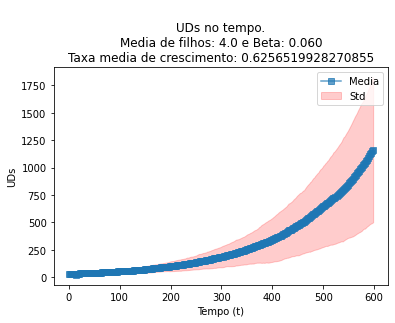

In [7]:
#Graph for each experiment
x = 1
y = 3

# Mean line
plt.plot(uM_behavior[y][x]['tempo'], uM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(uM_behavior[y][x]['tempo'], uM_behavior[y][x]['mean'] - uM_behavior[y][x]['std'],
                 uM_behavior[y][x]['mean'] + uM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Media de filhos: {ualphas[y]} e Beta: {ubetas[x]:.3f}
Taxa media de crescimento: {uM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

# 3. Experiment with initial UDs and Beta

### Mean of children (4)

In [9]:
#This experiment has mean of children: 4
media = 4
n = 50
halphas = np.linspace(10,n,int(n/10)) # Unidades inicias from 10 to 50
hbetas = np.arange(0.055, 0.065 + 0.005, 0.005) # Beta from 0.045 to 0.065
hM = np.empty((len(halphas), len(hbetas)), dtype=object)
punto_vista = 2
tiempo = 600
tempo = list(range(0,tiempo,punto_vista))
experiments = 40

start = time.time()
# For data of behaviour
datos_3 = np.empty((len(halphas), len(hbetas)), dtype=object)
print(uM.shape)

for i, iniciais in enumerate(halphas):
    for j, prob_morte  in enumerate(hbetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        original_media = media
        for experiment in range(1, experiments+1):
            #### Initialization
            ## Comunidades
            UD.uds = {}
            comunidades_disponibles = [i for i in range(1, (int(iniciais) // 10) + 1) for _ in range(10)]
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                instancias_ud.append(UD(id_ud, media, comunidades_disponibles.pop(0)))
            ## Variedades y repartirlas entre las comunidades
            for id_ud, ud in UD.uds.items():
                for _ in range(5):
                    ud.varieties.append(Variety())    
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                #uds_copy = dict(UD.uds)
                uds_copy = {id_ud: ud for id_ud, ud in UD.uds.items() if ud.activa}
                if not uds_copy:
                    # Only 0
                    print(f"acabó en el experimento {experiment} de la media {halphas[i]} con unidades {hbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                #any_ud_active = False
                #alive = len([1 for id, ud in uds_copy.items() if ud.activa])
#                 if alive > 200 and (media == original_media): #or media == original_media-1):
#                     media -= media//2
#                     if media >= 4:
#                         media = media //2
#                     print(media)
#                 elif alive < 150 and media < original_media:
#                     media = original_media
#                     print(media)                
                for id_ud, ud in uds_copy.items():
                    if ud.activa == True:
                        any_ud_active = True
                        ud.ter_filho()
                        ud.buscar_ud(int(media),0, True)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
#                 if not any_ud_active:
#                     # Only 0
#                     print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
#                     vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
#                     vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
#                     #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
#                     break
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
#                 if t%100 == 0:
#                     print(f"tamos en tiempo {t} con vivas {viv}")
            # Average Annual Population Growth
            # First 0 avoid errors 
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Get growth rate before the 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                # Growth rate
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            print(f"acabó en el experimento {experiment} de iniciales {halphas[i]} con prob de morte {hbetas[j]}")
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        media = original_media
        end_config = time.time()
        hM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration}
        datos_3[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of Initial UDs {iniciais} and beta {prob_morte:.3f} is: {end_config - star_configuration}
        """)
# Folders and save
folder_name = 'resultados_parametros_endogamy'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'morte_unidadesiniciais_endogamy.npy')
np.save(heat_std, hM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'morte_unidadesiniciais_datos_endogamy.npy')
np.save(behavior, datos_3)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(4, 5)
acabó en el experimento 1 de la media 10.0 con unidades 0.055
acabó en el experimento 1 de iniciales 10.0 con prob de morte 0.055
acabó en el experimento 2 de iniciales 10.0 con prob de morte 0.055
acabó en el experimento 3 de la media 10.0 con unidades 0.055
acabó en el experimento 3 de iniciales 10.0 con prob de morte 0.055
acabó en el experimento 4 de iniciales 10.0 con prob de morte 0.055
acabó en el experimento 5 de la media 10.0 con unidades 0.055
acabó en el experimento 5 de iniciales 10.0 con prob de morte 0.055
acabó en el experimento 6 de iniciales 10.0 con prob de morte 0.055
acabó en el experimento 7 de la media 10.0 con unidades 0.055
acabó en el experimento 7 de iniciales 10.0 con prob de morte 0.055
acabó en el experimento 8 de la media 10.0 con unidades 0.055
acabó en el experimento 8 de iniciales 10.0 con prob de morte 0.055
acabó en el experimento 9 de la media 10.0 con unidades 0.055
acabó en el experimento 9 de iniciales 10.0 con prob de morte 0.055
acabó en 

acabó en el experimento 33 de iniciales 10.0 con prob de morte 0.06
acabó en el experimento 34 de iniciales 10.0 con prob de morte 0.06
acabó en el experimento 35 de la media 10.0 con unidades 0.06
acabó en el experimento 35 de iniciales 10.0 con prob de morte 0.06
acabó en el experimento 36 de la media 10.0 con unidades 0.06
acabó en el experimento 36 de iniciales 10.0 con prob de morte 0.06
acabó en el experimento 37 de la media 10.0 con unidades 0.06
acabó en el experimento 37 de iniciales 10.0 con prob de morte 0.06
acabó en el experimento 38 de iniciales 10.0 con prob de morte 0.06
acabó en el experimento 39 de iniciales 10.0 con prob de morte 0.06
acabó en el experimento 40 de la media 10.0 con unidades 0.06
acabó en el experimento 40 de iniciales 10.0 con prob de morte 0.06

The total time of the configuration of Initial UDs 10.0 and beta 0.060 is: 982.3656764030457
        
acabó en el experimento 1 de la media 10.0 con unidades 0.065
acabó en el experimento 1 de iniciales 10.0

acabó en el experimento 17 de iniciales 10.0 con prob de morte 0.06999999999999999
acabó en el experimento 18 de la media 10.0 con unidades 0.06999999999999999
acabó en el experimento 18 de iniciales 10.0 con prob de morte 0.06999999999999999
acabó en el experimento 19 de la media 10.0 con unidades 0.06999999999999999
acabó en el experimento 19 de iniciales 10.0 con prob de morte 0.06999999999999999
acabó en el experimento 20 de la media 10.0 con unidades 0.06999999999999999
acabó en el experimento 20 de iniciales 10.0 con prob de morte 0.06999999999999999
acabó en el experimento 21 de la media 10.0 con unidades 0.06999999999999999
acabó en el experimento 21 de iniciales 10.0 con prob de morte 0.06999999999999999
acabó en el experimento 22 de iniciales 10.0 con prob de morte 0.06999999999999999
acabó en el experimento 23 de la media 10.0 con unidades 0.06999999999999999
acabó en el experimento 23 de iniciales 10.0 con prob de morte 0.06999999999999999
acabó en el experimento 24 de inic

acabó en el experimento 26 de iniciales 20.0 con prob de morte 0.06
acabó en el experimento 27 de la media 20.0 con unidades 0.06
acabó en el experimento 27 de iniciales 20.0 con prob de morte 0.06
acabó en el experimento 28 de iniciales 20.0 con prob de morte 0.06
acabó en el experimento 29 de iniciales 20.0 con prob de morte 0.06
acabó en el experimento 30 de iniciales 20.0 con prob de morte 0.06
acabó en el experimento 31 de iniciales 20.0 con prob de morte 0.06
acabó en el experimento 32 de iniciales 20.0 con prob de morte 0.06
acabó en el experimento 33 de iniciales 20.0 con prob de morte 0.06
acabó en el experimento 34 de iniciales 20.0 con prob de morte 0.06
acabó en el experimento 35 de iniciales 20.0 con prob de morte 0.06
acabó en el experimento 36 de la media 20.0 con unidades 0.06
acabó en el experimento 36 de iniciales 20.0 con prob de morte 0.06
acabó en el experimento 37 de iniciales 20.0 con prob de morte 0.06
acabó en el experimento 38 de iniciales 20.0 con prob de mor

acabó en el experimento 33 de la media 20.0 con unidades 0.06999999999999999
acabó en el experimento 33 de iniciales 20.0 con prob de morte 0.06999999999999999
acabó en el experimento 34 de iniciales 20.0 con prob de morte 0.06999999999999999
acabó en el experimento 35 de iniciales 20.0 con prob de morte 0.06999999999999999
acabó en el experimento 36 de la media 20.0 con unidades 0.06999999999999999
acabó en el experimento 36 de iniciales 20.0 con prob de morte 0.06999999999999999
acabó en el experimento 37 de iniciales 20.0 con prob de morte 0.06999999999999999
acabó en el experimento 38 de iniciales 20.0 con prob de morte 0.06999999999999999
acabó en el experimento 39 de iniciales 20.0 con prob de morte 0.06999999999999999
acabó en el experimento 40 de iniciales 20.0 con prob de morte 0.06999999999999999

The total time of the configuration of Initial UDs 20.0 and beta 0.070 is: 184.17278456687927
        
acabó en el experimento 1 de iniciales 30.0 con prob de morte 0.055
acabó en e

acabó en el experimento 23 de iniciales 30.0 con prob de morte 0.065
acabó en el experimento 24 de iniciales 30.0 con prob de morte 0.065
acabó en el experimento 25 de iniciales 30.0 con prob de morte 0.065
acabó en el experimento 26 de iniciales 30.0 con prob de morte 0.065
acabó en el experimento 27 de iniciales 30.0 con prob de morte 0.065
acabó en el experimento 28 de iniciales 30.0 con prob de morte 0.065
acabó en el experimento 29 de iniciales 30.0 con prob de morte 0.065
acabó en el experimento 30 de iniciales 30.0 con prob de morte 0.065
acabó en el experimento 31 de iniciales 30.0 con prob de morte 0.065
acabó en el experimento 32 de iniciales 30.0 con prob de morte 0.065
acabó en el experimento 33 de iniciales 30.0 con prob de morte 0.065
acabó en el experimento 34 de iniciales 30.0 con prob de morte 0.065
acabó en el experimento 35 de iniciales 30.0 con prob de morte 0.065
acabó en el experimento 36 de iniciales 30.0 con prob de morte 0.065
acabó en el experimento 37 de inic

KeyboardInterrupt: 

In [ ]:
# Dowload the documents
#As reference
n = 50
halphas = np.linspace(10,n,int(n/10)) # Unidades inicias from 10 to 50
hbetas = np.arange(0.055, 0.065 + 0.005, 0.005) # Beta from 0.045 to 0.075
#Folders
folder_name = 'resultados_parametros_endogamy'
heat_std = os.path.join(folder_name, 'morte_unidadesiniciais_endogamy.npy')
behavior = os.path.join(folder_name, 'morte_unidadesiniciais_datos_endogamy.npy')
## heatmap and mean
hM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
hM_behavior = np.load(behavior, allow_pickle=True)

In [ ]:
#Heatmap. 
alive_values = np.array([[entry['alive'] for entry in row] for row in hM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(hbetas)))
ax.set_yticks(np.arange(len(halphas)))
ax.set_xticklabels([f'{round(beta, 3)}' for beta in hbetas])
ax.set_yticklabels([f'{alpha:.1f}' for alpha in halphas])
for i in range(len(halphas)):
    for j in range(len(hbetas)):
        ax.text(j, i, f'{alive_values[i, j]:.0f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("UDs iniciais")
ax.set_xlabel("Beta")

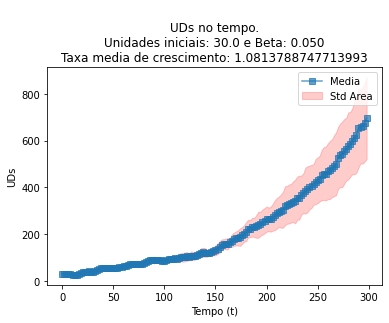

In [23]:
x = 0
y = 2

# MEan line
plt.plot(hM_behavior[y][x]['tempo'], hM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(hM_behavior[y][x]['tempo'], hM_behavior[y][x]['mean'] - hM_behavior[y][x]['std'],
                 hM_behavior[y][x]['mean'] + hM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std Area')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Unidades iniciais: {halphas[y]} e Beta: {hbetas[x]:.3f}
Taxa media de crescimento: {hM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

# Now experimentos with endogamy but with  distance penalty

# UD Class for endogamy
## With distance "penalty"

In [22]:
## CLase UD 
## Class with endogamy. In other words, UDs in this model belong to the same clan and the only criteria is 
# the incest rule and some probabilities related to distance. 
# With distane "penalty"
#This particular Class is used to set a limit in the number of UD on the model 0,1,2,3,4,5,7,8
###Relações na lista de parentes
#0. Pais do homem [0]
#1. Pais da mulher [1]
#2. Filhos [2]
#3. Avos [3] 
#4. Irmãos [4]
#5. Tios [5]
#6. Primos [6]
#7. Netos [7]
#8. Sobrinhos [8]
#9. Cassais passados [9]

### Filhos tem sexo e idade
#[sexo, idade]

class UD:
    #Dict de todas as UDs
    uds = {}

    def __init__(self, id_ud, media, community):
        self.id = id_ud
        self.parentes = [None]*10
        self.age = 1
        self.filhos = [None] * (np.random.poisson(media))
        self.uds[id_ud] = self
        self.activa = True 
        self.varieties = []
        self.community = community

    def ter_filho(self):
        # Tem espaco para ter filhos?, aleatoriamente para nao ter filhos todo ano. 
        if None in self.filhos and random.random() <= 0.3:
            # Coloca o filho no primeiro None
            for i in range(len(self.filhos)):
                if self.filhos[i] is None:
                    self.filhos[i] = [random.choice([0, 1]), 0] #[sexo, idade] e no sexo: 0 é feminino e 1 é masculino
                    break
        else:
            pass #print(f"Unidade {self.id} No tem para ter filhos!")

    def incrementar_idade(self):
        self.age += 1
        ## idade dos filhos no self.filhos
        for i in range(len(self.filhos)):
            if self.filhos[i] is not None:
                self.filhos[i][1] += 1
            else:
                break

    def death_probability(self, beta):
        alpha = 0.01
        delta = 0.00
        mortality_rate = alpha * math.exp(beta * (self.age)) + delta

        if random.random() < mortality_rate:
            self.activa = False

    def buscar_ud(self, media, matrilinear, locality): #metodo para buscar e reproducir.
        #Function to get a random couple
        def select_new_ud(selected_ud, uds_disponiveis, scale_factor=1.0):
            if len(uds_disponiveis) == 0:
                return False
            # Get communities
            communities = np.array([ud.community for ud in uds_disponiveis])
            # Probabilities
            probabilities = np.exp(-scale_factor * np.abs(communities - selected_ud.community))
            # Normalice
            probabilities_normalized = probabilities / np.sum(probabilities)
            # Choose
            choosen_ud = np.random.choice(uds_disponiveis, p=probabilities_normalized)

            return choosen_ud
        
        #Função para facilitar a busqueda de ids dentro da lista de parentes.
        def is_id_in_nested_lists(id_ud, nested_list):
            if id_ud in nested_list:
                return True
            for sublist in nested_list:
                if isinstance(sublist, list) and is_id_in_nested_lists(id_ud, sublist):
                    return True
            return False
        
        #Função para facilitar a busqueda de filhos segundo o sexo
        def filho_e_idade(self, sexo):
            for i in range(len(self.filhos)):
                filho = self.filhos[i]
                #Se o sexo é o que estamos procurando e se a idade é permitida para o casamento
                if filho is not None and filho[0] == sexo and filho[1] > 13:
                    return (True, i, filho[1])  # True, a posição e a idade

            return (False, None, None)  # False, None e None
        
        filha_disponivel, posição_filha, idade_filha = filho_e_idade(self, 0) #Se a unidade tem uma filha disponivel para procurar esposa
        if filha_disponivel:
            uds_disponiveis = [ud for id_ud, ud in self.uds.items() if
                    id_ud != self.id and #Que a UD não seja self
                    not is_id_in_nested_lists(id_ud, [self.parentes[i] for i in [0, 1, 2, 3, 4, 5, 7, 8]]) and # Que a UD não seja um parent
                    filho_e_idade(ud,1)[0] and #Que tenha um filho
                    abs(filho_e_idade(ud,1)[2] - idade_filha) <= 13 #Que a diferença entre as idades não seja maior a 10
                      ]
            new_couple = select_new_ud(self, uds_disponiveis)
            
            if new_couple:
                cassal_id = new_couple.id
                filho_disponivel, posição_filho, idade_filho = filho_e_idade(UD.uds[cassal_id], 1)
                #print(filho_disponivel, posição_filho, idade_filho)
                #Agregar no espaço de casais passados [9]
                if self.parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.parentes[9] = [cassal_id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.parentes[9].append(cassal_id)
                if self.uds[cassal_id].parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.uds[cassal_id].parentes[9] = [self.id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.uds[cassal_id].parentes[9].append(self.id)   

                #### Criar um novo filho e asignar os parentes
                novo_id = max(self.uds) + 1
                if locality == True:
                    novo_nodo = UD(novo_id, media, self.uds[cassal_id].community)
                else:
                    novo_nodo = UD(novo_id, media, self.community)
                novo_nodo.parentes[0] = self.id   # Pais do homem [0]
                novo_nodo.parentes[1] = cassal_id # Pais da mulher [1] 
                
                #####Avos[3]
                # IDs do pai
                padre_self = self.parentes[0]
                madre_self = self.parentes[1]
                # IDs da mae
                pareja = self.uds[cassal_id]
                padre_pareja = pareja.parentes[0]
                madre_pareja = pareja.parentes[1]
                # Agregar os pais dos pais do novo_nodo como avos
                novo_nodo.parentes[3] = [valor for valor in [padre_self, madre_self, padre_pareja, madre_pareja] if valor is not None]
                ###Proceso de atualização: netos
                # Se novo_nodo tem avos 
                if None not in novo_nodo.parentes[3]:
                    # IDs dos avos de novo_nodo
                    abuelos_ids = novo_nodo.parentes[3]
                # Agregar aos avos o novo_nodo como neto.
                for abuelo_id in abuelos_ids:
                    if abuelo_id is not None:
                        abuelo = self.uds[abuelo_id]
                        if abuelo.parentes[7] is None:
                            abuelo.parentes[7] = [novo_nodo.id]
                        else:
                            abuelo.parentes[7].append(novo_nodo.id)
                
                #### Irmãos [4]
                hermanos_ids = []
                if novo_nodo.parentes[0] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte do pai)
                    padre_nuevo = self.uds[novo_nodo.parentes[0]]
                    if padre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(padre_nuevo.parentes[2])
                if novo_nodo.parentes[1] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte da mãe)
                    madre_nuevo = self.uds[novo_nodo.parentes[1]]
                    if madre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(madre_nuevo.parentes[2])
                # Não ter o id de novo_nodo como irmão
                hermanos_ids = [hermano_id for hermano_id in hermanos_ids if hermano_id != novo_nodo.id]
                # Agregar aos irmãos de novo_nodo
                novo_nodo.parentes[4] = hermanos_ids
                
                ##Proceso de atualização: irmãos
                # ID de novo_nodo nos irmãos existentes
                for hermano_id in hermanos_ids:
                    hermano = self.uds[hermano_id]
                    if hermano.parentes[4] is None:
                        hermano.parentes[4] = [novo_nodo.id]
                    else:
                        hermano.parentes[4].append(novo_nodo.id)
                #####Tios[5]
                # IDs dos avos de novo_nodo
                abuelos_ids = novo_nodo.parentes[3]
                
                # Iterar nos avos para encontrar os tios
                tios_ids = [hermano_id for abuelo_id in abuelos_ids if abuelo_id is not None
                            for hermano_id in self.uds[abuelo_id].parentes[2] if hermano_id is not None
                            if hermano_id != novo_nodo.parentes[0] and hermano_id != novo_nodo.parentes[1]]
                # Agregar os IDs dos tios no novo_nodo
                novo_nodo.parentes[5] = tios_ids
                
                ##Proceso de atualização: sobrinhos
                # Actualizar os sobrinhos dos tios.
                for tio_id in tios_ids:
                    if tio_id is not None:
                        tio = self.uds[tio_id]
                        if tio.parentes[8] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            tio.parentes[8] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            tio.parentes[8].append(novo_nodo.id)
                
                #### Primos[6]
                primos_ids = [primo_id for tio_id in tios_ids if tio_id is not None
                            for tio in [self.uds[tio_id]] if tio.parentes[2] is not None
                            for primo_id in tio.parentes[2] if primo_id is not None and primo_id != novo_nodo.id]

                # Agregar os IDs dos primos no novo_nodo
                novo_nodo.parentes[6] = primos_ids
                
                ##Proceso de atualização: sobrinhos
                for primo_id in primos_ids:
                    if primo_id is not None:
                        primo = self.uds[primo_id]
                        if primo.parentes[6] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            primo.parentes[6] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            primo.parentes[6].append(novo_nodo.id)
                            
                ####Sobrinos[8] 
                sobrinos_ids = [sobrino_id for hermano_id in hermanos_ids if hermano_id is not None
                                for hermano in [self.uds[hermano_id]] if hermano.parentes[2] is not None
                                for sobrino_id in hermano.parentes[2] if sobrino_id is not None and sobrino_id != novo_nodo.id]

                # Agregar os IDs dos sobrinhos no novo_nodo
                novo_nodo.parentes[8] = sobrinos_ids
                
                ##Proceso de atualização: tios
                for sobrino_id in sobrinos_ids:
                    if sobrino_id is not None:
                        sobrino = self.uds[sobrino_id]
                        if sobrino.parentes[5] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            sobrino.parentes[5] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            sobrino.parentes[5].append(novo_nodo.id)
                            
                            
                ### Eliminar os filhos utilizados no processo
                self.filhos.pop(posição_filha)
                self.uds[cassal_id].filhos.pop(posição_filho)
                
                # colcoar o novo filho dos pais
                if self.parentes[2] is None:
                    self.parentes[2] = [novo_id]
                else:
                    self.parentes[2].append(novo_id)
                if self.uds[cassal_id].parentes[2] is None:
                    self.uds[cassal_id].parentes[2] = [novo_id]
                else:
                    self.uds[cassal_id].parentes[2].append(novo_id)
                
                # Herdar sementes
                novo_nodo.heredar(matrilinear)
                
                #return None
            else:
                #print(f"UD {self.id} não achou cassal.")
                return None

        else:
            #print(f"UD {self.id} não achou ninguem")
            return None

    def heredar(self, matrilinear): #Metodo da herança de sementes.
        vm = UD.uds[self.parentes[1]].varieties
        vp = UD.uds[self.parentes[0]].varieties
        heredar_mae = math.ceil((matrilinear * len(vm))/100)
        heredar_pai = math.ceil(((100-matrilinear) * len(vp))/100)
        vari_mae = vm[0:heredar_mae] #as primeiras variedades
        vari_pai = vp[0:heredar_pai] #as primeiras variedades
        # Mutacao
#        if random.random() < 0.001:
#            # uma aleatoria
#            variedad_a_mutar = random.choice(vari_mae + vari_pai)
#            # mutacao
#            variedad_a_mutar.mutation()

        # Heredar as variedades
        self.varieties.extend(vari_mae + vari_pai)

# Experiments with beta fixed

In [30]:
#This experiment has the beta fixed in 0.06
prob_morte = 0.06
n = 4
m = 50
malphas = np.linspace(1,n,n) # Average number of children: from 1 to n
mbetas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
mM = np.empty((len(malphas), len(mbetas)), dtype=object)
punto_vista = 2
tiempo = 600
tempo = list(range(0,tiempo,punto_vista))
experiments = 40

# For data of behaviour
datos_1 = np.empty((len(malphas), len(mbetas)), dtype=object)
print(mM.shape)
start = time.time()

for i, media in enumerate(malphas):
    for j, iniciais  in enumerate(mbetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        original_media = media
        for experiment in range(1, experiments+1):
            #### Initialization
            ## Comunidades
            UD.uds = {}
            comunidades_disponibles = [i for i in range(1, (int(iniciais) // 10) + 1) for _ in range(10)]
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                instancias_ud.append(UD(id_ud, media, comunidades_disponibles.pop(0)))
            ## Variedades y repartirlas entre las comunidades
            for id_ud, ud in UD.uds.items():
                for _ in range(5):
                    ud.varieties.append(Variety())    
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                #uds_copy = dict(UD.uds)
                uds_copy = {id_ud: ud for id_ud, ud in UD.uds.items() if ud.activa}
                if not uds_copy:
                    # Only 0
                    print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                #any_ud_active = False
                #alive = len([1 for id, ud in uds_copy.items() if ud.activa])
#                 if alive > 200 and (media == original_media): #or media == original_media-1):
#                     media -= media//2
#                     if media >= 4:
#                         media = media //2
#                     print(media)
#                 elif alive < 150 and media < original_media:
#                     media = original_media
#                     print(media)                
                for id_ud, ud in uds_copy.items():
                    if ud.activa == True:
                        any_ud_active = True
                        ud.ter_filho()
                        ud.buscar_ud(int(media),0, True)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
#                 if not any_ud_active:
#                     # Only 0
#                     print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
#                     vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
#                     vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
#                     #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
#                     break
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
#                 if t%100 == 0:
#                     print(f"tamos en tiempo {t} con vivas {viv}")
            # Average Annual Population Growth
            # First 0 avoid errors 
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Get growth rate before the 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                # Growth rate
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        media = original_media
        end_config = time.time()
        mM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration}
        datos_1[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of mean {media} and initial UDs {iniciais} is  {end_config - star_configuration}
        """)
# Folder
folder_name = 'resultados_parametros_endogamy'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'filhos_unidadesiniciais_endogamy_distance.npy')
np.save(heat_std, mM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'filhos_unidadesiniciais_datos_endogamy_distance.npy')
np.save(behavior, datos_1)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(4, 5)
acabó en el experimento 1 de la media 1.0 con unidades 10.0
acabó en el experimento 2 de la media 1.0 con unidades 10.0

The total time of the configuration of mean 1.0 and initial UDs 10.0 is  0.01860785484313965
        
acabó en el experimento 1 de la media 1.0 con unidades 20.0
acabó en el experimento 2 de la media 1.0 con unidades 20.0

The total time of the configuration of mean 1.0 and initial UDs 20.0 is  0.028197288513183594
        
acabó en el experimento 1 de la media 1.0 con unidades 30.0
acabó en el experimento 2 de la media 1.0 con unidades 30.0

The total time of the configuration of mean 1.0 and initial UDs 30.0 is  0.2420368194580078
        
acabó en el experimento 1 de la media 1.0 con unidades 40.0
acabó en el experimento 2 de la media 1.0 con unidades 40.0

The total time of the configuration of mean 1.0 and initial UDs 40.0 is  0.04180455207824707
        
acabó en el experimento 1 de la media 1.0 con unidades 50.0
acabó en el experimento 2 de la media 1.0

In [33]:
# Dowload the documents
#As a reference
n = 4
m = 50
malphas = np.linspace(1,n,n) # Average number of children: from 1 to n
mbetas = np.linspace(10,m,int(m/10)) # Initial UDs: from 10 to m
#Folders
folder_name = 'resultados_parametros_endogamy'
heat_std = os.path.join(folder_name, 'filhos_unidadesiniciais_endogamy_distance.npy')
behavior = os.path.join(folder_name, 'filhos_unidadesiniciais_datos_endogamy_distance.npy')
## heatmap and mean
mM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
mM_behavior = np.load(behavior, allow_pickle=True)

Text(0.5, 0, 'Unidades iniciais')

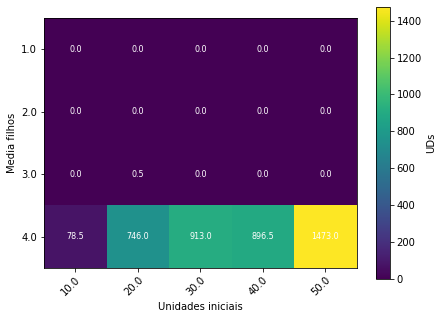

In [34]:
#Heatmap. 
#Get the vales from the document.
alive_values = np.array([[entry['alive'] for entry in row] for row in mM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(mbetas)))
ax.set_yticks(np.arange(len(malphas)))
ax.set_xticklabels(mbetas)
ax.set_yticklabels(malphas)
#Size
for i in range(len(malphas)):
    for j in range(len(mbetas)):
        ax.text(j, i, f'{alive_values[i, j]:.1f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Unidades iniciais")

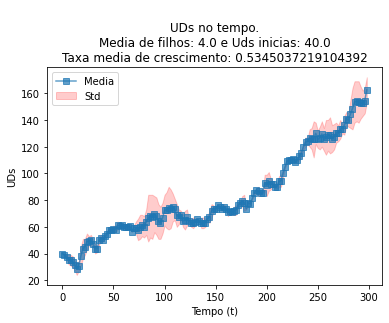

In [29]:
#Graph of experiment with mean and std
x = 3
y = 3

# Main line
plt.plot(mM_behavior[y][x]['tempo'], mM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(mM_behavior[y][x]['tempo'], mM_behavior[y][x]['mean'] - mM_behavior[y][x]['std'],
                 mM_behavior[y][x]['mean'] + mM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Media de filhos: {malphas[y]} e Uds inicias: {mbetas[x]}
Taxa media de crescimento: {mM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

# Experiment of children and beta.
UDs iniciais 30

In [37]:
#This experiment has Uds inicias in 30
iniciais = 30
n = 4
ualphas = np.linspace(1,n,n) # Average number of children: from 1 to n
ubetas = np.arange(0.05, 0.065 + 0.005, 0.005) # Beta from 0.045 to 0.065
uM = np.empty((len(ualphas), len(ubetas)), dtype=object)
punto_vista = 2
tiempo = 600
tempo = list(range(0,tiempo,punto_vista))
experiments = 40

start = time.time()
# For data of behaviour
datos_2 = np.empty((len(ualphas), len(ubetas)), dtype=object)
print(uM.shape)

for i, media in enumerate(ualphas):
    for j, prob_morte  in enumerate(ubetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        original_media = media
        for experiment in range(1, experiments+1):
            #### Initialization
            ## Comunidades
            UD.uds = {}
            comunidades_disponibles = [i for i in range(1, (int(iniciais) // 10) + 1) for _ in range(10)]
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                instancias_ud.append(UD(id_ud, media, comunidades_disponibles.pop(0)))
            ## Variedades y repartirlas entre las comunidades
            for id_ud, ud in UD.uds.items():
                for _ in range(5):
                    ud.varieties.append(Variety())    
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                #uds_copy = dict(UD.uds)
                uds_copy = {id_ud: ud for id_ud, ud in UD.uds.items() if ud.activa}
                if not uds_copy:
                    # Only 0
                    print(f"acabó en el experimento {experiment} de la media {ualphas[i]} con unidades {ubetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                #any_ud_active = False
                #alive = len([1 for id, ud in uds_copy.items() if ud.activa])
#                 if alive > 200 and (media == original_media): #or media == original_media-1):
#                     media -= media//2
#                     if media >= 4:
#                         media = media //2
#                     print(media)
#                 elif alive < 150 and media < original_media:
#                     media = original_media
#                     print(media)                
                for id_ud, ud in uds_copy.items():
                    any_ud_active = True
                    ud.ter_filho()
                    ud.buscar_ud(int(media),0, True)
                    ud.incrementar_idade()
                    ud.death_probability(prob_morte)
#                 if not any_ud_active:
#                     # Only 0
#                     print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
#                     vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
#                     vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
#                     #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
#                     break
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
#                 if t%100 == 0:
#                     print(f"tamos en tiempo {t} con vivas {viv}")
            # Average Annual Population Growth
            # First 0 avoid errors 
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Get growth rate before the 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                # Growth rate
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        media = original_media
        end_config = time.time()
        uM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration}
        datos_2[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of mean {original_media} and beta {prob_morte:.3f} is  {end_config - star_configuration}
        """)
# Folders and save
folder_name = 'resultados_parametros_endogamy'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'filhos_morte_endogamy_distance.npy')
np.save(heat_std, uM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'filhos_morte_datos_endogamy_distance.npy')
np.save(behavior, datos_2)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(4, 5)
acabó en el experimento 1 de la media 1.0 con unidades 0.05
acabó en el experimento 2 de la media 1.0 con unidades 0.05

The total time of the configuration of mean 1.0 and beta 0.050 is  0.05347180366516113
        
acabó en el experimento 1 de la media 1.0 con unidades 0.055
acabó en el experimento 2 de la media 1.0 con unidades 0.055

The total time of the configuration of mean 1.0 and beta 0.055 is  0.03918719291687012
        
acabó en el experimento 1 de la media 1.0 con unidades 0.06
acabó en el experimento 2 de la media 1.0 con unidades 0.06

The total time of the configuration of mean 1.0 and beta 0.060 is  0.034731149673461914
        
acabó en el experimento 1 de la media 1.0 con unidades 0.065
acabó en el experimento 2 de la media 1.0 con unidades 0.065

The total time of the configuration of mean 1.0 and beta 0.065 is  0.022722482681274414
        
acabó en el experimento 1 de la media 1.0 con unidades 0.06999999999999999
acabó en el experimento 2 de la media 1.0 co

In [40]:
# Dowload the documents
#As reference
n = 4
ualphas = np.linspace(1,n,n) # Average number of children: from 1 to n
ubetas = np.arange(0.05, 0.065 + 0.005, 0.005) # Beta from 0.05 to 0.075
#Folders
folder_name = 'resultados_parametros_endogamy'
heat_std = os.path.join(folder_name, 'filhos_morte_endogamy_distance.npy')
behavior = os.path.join(folder_name, 'filhos_morte_datos_endogamy_distance.npy')
## heatmap and mean
uM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
uM_behavior = np.load(behavior, allow_pickle=True)

Text(0.5, 0, 'Beta')

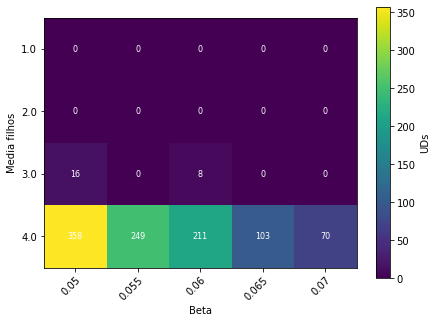

In [41]:
#Heatmap. 
alive_values = np.array([[entry['alive'] for entry in row] for row in uM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(ubetas)))
ax.set_yticks(np.arange(len(ualphas)))
ax.set_xticklabels([f'{round(beta, 3)}' for beta in ubetas])
ax.set_yticklabels([f'{alpha:.1f}' for alpha in ualphas])
# Size
for i in range(len(ualphas)):
    for j in range(len(ubetas)):
        ax.text(j, i, f'{alive_values[i, j]:.0f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("Media filhos")
ax.set_xlabel("Beta")

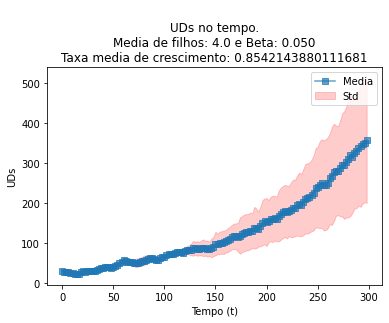

In [44]:
#Graph for each experiment
x = 0
y = 3

# Mean line
plt.plot(uM_behavior[y][x]['tempo'], uM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(uM_behavior[y][x]['tempo'], uM_behavior[y][x]['mean'] - uM_behavior[y][x]['std'],
                 uM_behavior[y][x]['mean'] + uM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Media de filhos: {ualphas[y]} e Beta: {ubetas[x]:.3f}
Taxa media de crescimento: {uM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

## Experiment with initial UDs and Beta

### Mean of children (4)

In [45]:
#This experiment has mean of children: 4
media = 4
n = 50
halphas = np.linspace(10,n,int(n/10)) # Unidades inicias from 10 to 50
hbetas = np.arange(0.05, 0.07 + 0.005, 0.005) # Beta from 0.045 to 0.065
hM = np.empty((len(halphas), len(hbetas)), dtype=object)
punto_vista = 2
tiempo = 600
tempo = list(range(0,tiempo,punto_vista))
experiments = 40

start = time.time()
# For data of behaviour
datos_3 = np.empty((len(halphas), len(hbetas)), dtype=object)
print(uM.shape)

for i, iniciais in enumerate(halphas):
    for j, prob_morte  in enumerate(hbetas):
        list_alive_UDs = []
        list_vivas_puntos_vista = []
        tasas_crecimiento = []
        star_configuration = time.time()
        original_media = media
        for experiment in range(1, experiments+1):
            #### Initialization
            ## Comunidades
            UD.uds = {}
            comunidades_disponibles = [i for i in range(1, (int(iniciais) // 10) + 1) for _ in range(10)]
            instancias_ud = []
            for id_ud in range(1, int(iniciais) + 1):
                instancias_ud.append(UD(id_ud, media, comunidades_disponibles.pop(0)))
            ## Variedades y repartirlas entre las comunidades
            for id_ud, ud in UD.uds.items():
                for _ in range(5):
                    ud.varieties.append(Variety())    
            # Lists for graphs
            vivas_puntos_vista = [int(iniciais)]
            vivas_tasa_crecimiento = [int(iniciais)]
            mortas_puntos_vista = [0]
            # Simulation
            for t in range(1, tiempo):
                #uds_copy = dict(UD.uds)
                uds_copy = {id_ud: ud for id_ud, ud in UD.uds.items() if ud.activa}
                if not uds_copy:
                    # Only 0
                    print(f"acabó en el experimento {experiment} de la media {halphas[i]} con unidades {hbetas[j]}")
                    vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
                    vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
                    #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
                    break
                #any_ud_active = False
                #alive = len([1 for id, ud in uds_copy.items() if ud.activa])
#                 if alive > 200 and (media == original_media): #or media == original_media-1):
#                     media -= media//2
#                     if media >= 4:
#                         media = media //2
#                     print(media)
#                 elif alive < 150 and media < original_media:
#                     media = original_media
#                     print(media)                
                for id_ud, ud in uds_copy.items():
                    if ud.activa == True:
                        any_ud_active = True
                        ud.ter_filho()
                        ud.buscar_ud(int(media),0, True)
                        ud.incrementar_idade()
                        ud.death_probability(prob_morte)
#                 if not any_ud_active:
#                     # Only 0
#                     print(f"acabó en el experimento {experiment} de la media {malphas[i]} con unidades {mbetas[j]}")
#                     vivas_puntos_vista.extend([0] * (int((tiempo/punto_vista)-(len(vivas_puntos_vista)))))
#                     vivas_tasa_crecimiento.extend([0] * (int((tiempo)-(len(vivas_tasa_crecimiento)))))
#                     #mortas_puntos_vista.extend([unidades_iniciais] * (tiempo - t))
#                     break
                # Collecting data
                vivas_tasa_crecimiento.append(len([ud for id, ud in uds_copy.items() if ud.activa]))
                if t % punto_vista == 0:
                    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
                    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
                    vivas_puntos_vista.append(viv)
#                     mortas_puntos_vista.append(mort)
#                 if t%100 == 0:
#                     print(f"tamos en tiempo {t} con vivas {viv}")
            # Average Annual Population Growth
            # First 0 avoid errors 
            indice_primer_cero = np.where(np.array(vivas_tasa_crecimiento) == 0)[0]
            if len(indice_primer_cero) > 0:
                # Get growth rate before the 0
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento[:indice_primer_cero[0] - 1]) / vivas_tasa_crecimiento[:-1][:indice_primer_cero[0] - 2] * 100)
            else:
                # Growth rate
                tasas_crecimiento.append(np.diff(vivas_tasa_crecimiento) / vivas_tasa_crecimiento[:-1] * 100)
            # Collect the data
            list_alive_UDs.append(len([ud for id, ud in uds_copy.items() if ud.activa == True])) #For heatmap
            list_vivas_puntos_vista.append(vivas_puntos_vista)
            #print(f"""
            #    Acabó la simulacion con media de {int(media)} y {int(iniciais)} unidades iniciales. Prob de morte: {prob_morte}
            #    poblacion total al final de la simulación: {len([ud for id, ud in uds_copy.items() if ud.activa == True])}""")
        media = original_media
        end_config = time.time()
        hM[i][j] = {'alive': np.mean(list_alive_UDs),
                    'std': np.std(list_alive_UDs),
                    'time used': end_config - star_configuration}
        datos_3[i][j] = {'tempo': tempo, 
                         'mean': np.mean(list_vivas_puntos_vista, axis=0), 
                         'std':  np.std(list_vivas_puntos_vista, axis=0),
                         'growth rate': np.mean([np.mean(lista) for lista in tasas_crecimiento])}
        print(f"""
The total time of the configuration of Initial UDs {iniciais} and beta {prob_morte:.3f} is: {end_config - star_configuration}
        """)
# Folders and save
folder_name = 'resultados_parametros_endogamy'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Heatmap and std
heat_std = os.path.join(folder_name, 'morte_unidadesiniciais_endogamy_distance.npy')
np.save(heat_std, hM)
# Behavior of experiments
behavior = os.path.join(folder_name, 'morte_unidadesiniciais_datos_endogamy_distance.npy')
np.save(behavior, datos_3)
now = datetime.now()
finish = time.time()
print(f"""
It finished at: {now}
It lasted {finish-start}
""")
print("done")

(4, 5)

The total time of the configuration of Initial UDs 10.0 and beta 0.050 is: 0.7146270275115967
        

The total time of the configuration of Initial UDs 10.0 and beta 0.055 is: 2.239110231399536
        

The total time of the configuration of Initial UDs 10.0 and beta 0.060 is: 0.4858236312866211
        
acabó en el experimento 1 de la media 10.0 con unidades 0.065

The total time of the configuration of Initial UDs 10.0 and beta 0.065 is: 0.12500309944152832
        
acabó en el experimento 1 de la media 10.0 con unidades 0.06999999999999999

The total time of the configuration of Initial UDs 10.0 and beta 0.070 is: 0.10937309265136719
        
acabó en el experimento 1 de la media 10.0 con unidades 0.07499999999999998
acabó en el experimento 2 de la media 10.0 con unidades 0.07499999999999998

The total time of the configuration of Initial UDs 10.0 and beta 0.075 is: 0.04620862007141113
        

The total time of the configuration of Initial UDs 20.0 and beta 0.050 is: 5

In [46]:
# Dowload the documents
#As reference
n = 50
halphas = np.linspace(10,n,int(n/10)) # Unidades inicias from 10 to 50
hbetas = np.arange(0.05, 0.07 + 0.005, 0.005) # Beta from 0.045 to 0.075
#Folders
folder_name = 'resultados_parametros_endogamy'
heat_std = os.path.join(folder_name, 'morte_unidadesiniciais_endogamy_distance.npy')
behavior = os.path.join(folder_name, 'morte_unidadesiniciais_datos_endogamy_distance.npy')
## heatmap and mean
hM_datos = np.load(heat_std, allow_pickle=True)
## behavior for experiments
hM_behavior = np.load(behavior, allow_pickle=True)

Text(0.5, 0, 'Beta')

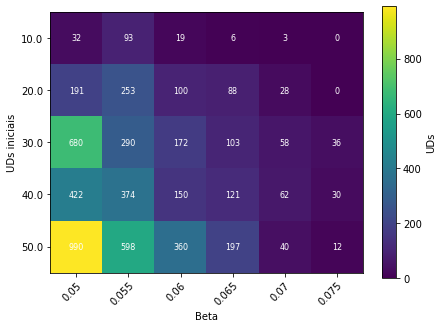

In [47]:
#Heatmap. 
alive_values = np.array([[entry['alive'] for entry in row] for row in hM_datos])
fig,ax = plt.subplots(1,1, figsize=(7, 5), facecolor="white")
IM = ax.imshow(alive_values)
cbar = fig.colorbar(IM, ax=ax, label="UDs")
ax.set_xticks(np.arange(len(hbetas)))
ax.set_yticks(np.arange(len(halphas)))
ax.set_xticklabels([f'{round(beta, 3)}' for beta in hbetas])
ax.set_yticklabels([f'{alpha:.1f}' for alpha in halphas])
for i in range(len(halphas)):
    for j in range(len(hbetas)):
        ax.text(j, i, f'{alive_values[i, j]:.0f}', ha="center", va="center", color="w", fontsize=8)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylabel("UDs iniciais")
ax.set_xlabel("Beta")

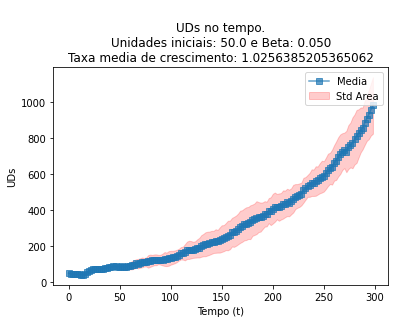

In [48]:
x = 0
y = 4

# MEan line
plt.plot(hM_behavior[y][x]['tempo'], hM_behavior[y][x]['mean'], 's-', label='Media', alpha=0.7)

# Std
plt.fill_between(hM_behavior[y][x]['tempo'], hM_behavior[y][x]['mean'] - hM_behavior[y][x]['std'],
                 hM_behavior[y][x]['mean'] + hM_behavior[y][x]['std'], color='red', alpha=0.2, label='Std Area')

plt.xlabel('Tempo (t)')
plt.ylabel('UDs')
plt.title(f'''
UDs no tempo.
Unidades iniciais: {halphas[y]} e Beta: {hbetas[x]:.3f}
Taxa media de crescimento: {hM_behavior[y][x]['growth rate']}''')
plt.legend()
plt.show()

NameError: name 'p' is not defined